In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
              std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
])

In [10]:
# for i in range(8):
#     print(img_2m[i,:,:].mean().compute(), img_2m[i,:,:].std().compute())

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [11]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [12]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform, comb='all') # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform, comb='all')

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [13]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [14]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [15]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

## TRY A LOCAL IMPLEMENTATION OF UNET

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [18]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

## call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
model = unet11_MS(pretrained=False)
# model = UNet(in_channels=8, n_classes=1, padding=True)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


# record time for one epoch
t0 = time.time()
for epoch in range(100):
    
    try:
        te = time.time()

        epoch_i = epoch+1
        print('on epoch {}'.format(epoch_i))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        for i, (inputs_, targets_) in enumerate(tl):

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1


            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

        losses_ep.append(losses)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))
    
    except Exception as e:
        print('something happened')
        print(e)
        break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

num_bands is  8
Let's use 4 GPUs!
batchsize,  8
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 160.7006435394287 seconds
on epoch 2
epoch: 2, LOSS=1.4172115325927734, ROC_AUC=0.7040457296621132 
time for epoch 2: 162.9253978729248 seconds
on epoch 3
time for epoch 3: 177.73637008666992 seconds
on epoch 4
epoch: 4, LOSS=1.4062480926513672, ROC_AUC=0.7164451601528213 
time for epoch 4: 153.70243883132935 seconds
on epoch 5
time for epoch 5: 159.88105249404907 seconds
on epoch 6
epoch: 6, LOSS=1.3714094161987305, ROC_AUC=0.7423092519465389 
time for epoch 6: 163.86135482788086 seconds
on epoch 7
time for epoch 7: 153.4472906589508 seconds
on epoch 8
epoch: 8, LOSS=1.3296482563018799, ROC_AUC=0.7471847856462335 
time for epoch 8: 157.4848132133484 seconds
on epoch 9
time for epoch 9: 155.57565450668335 seconds
on epoch 10
epoch: 10, LOSS=1.3034651279449463, ROC_AUC=0.7540617595355752 
time for epoch 10: 153.96762323379517 seconds
on epoch 11
time for epoch 11: 156.95920395851135 seconds
on epoch 12
epoch: 12, LOSS=1.2568544149398804, ROC_AUC=0.779953502790819 
time

time for epoch 93: 158.12615323066711 seconds
on epoch 94
epoch: 94, LOSS=0.5815819501876831, ROC_AUC=0.9603716650689206 
time for epoch 94: 153.23697900772095 seconds
on epoch 95
time for epoch 95: 156.33042359352112 seconds
on epoch 96
epoch: 96, LOSS=0.5949772596359253, ROC_AUC=0.9614454391570415 
time for epoch 96: 157.10866808891296 seconds
on epoch 97
time for epoch 97: 163.2266116142273 seconds
on epoch 98
epoch: 98, LOSS=0.5778764486312866, ROC_AUC=0.9611948463830465 
time for epoch 98: 155.8757927417755 seconds
on epoch 99
time for epoch 99: 155.82078981399536 seconds
on epoch 100
epoch: 100, LOSS=0.5782655477523804, ROC_AUC=0.9588463103428051 
time for epoch 100: 153.86985182762146 seconds
total time:  15706.355118989944


In [19]:
# encoder = models.vgg11(pretrained=False).features
# encoder[0]

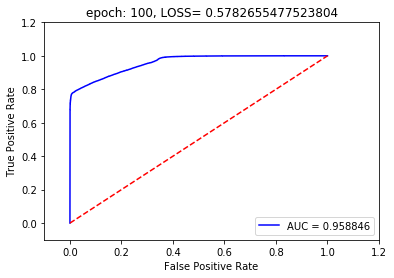

In [20]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [21]:
model.eval()

DataParallel(
  (module): UNet11_MS(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace)
      (13): Conv2d(512, 512, kernel_siz

Validation batch: 0, LOSS=0.9908401966094971, ROC_AUC=0.9340415667684497 


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


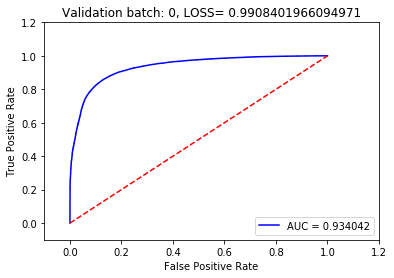

Validation batch: 1, LOSS=0.8698642253875732, ROC_AUC=0.9436340604881951 


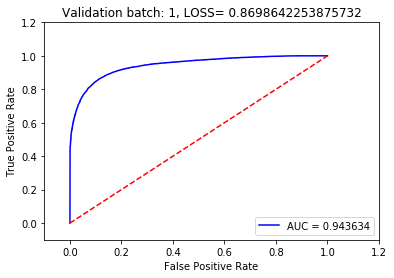

Validation batch: 2, LOSS=1.444879412651062, ROC_AUC=0.8955774152560939 


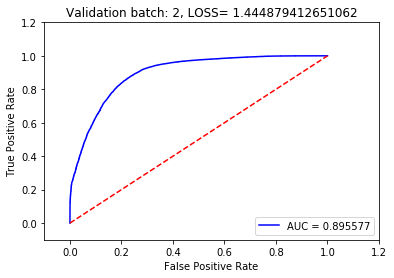

Validation batch: 3, LOSS=0.9714056849479675, ROC_AUC=0.931271845421102 


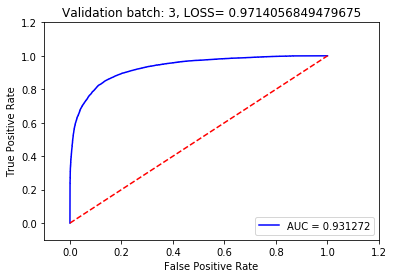

Validation batch: 4, LOSS=1.5247008800506592, ROC_AUC=0.90216277333145 


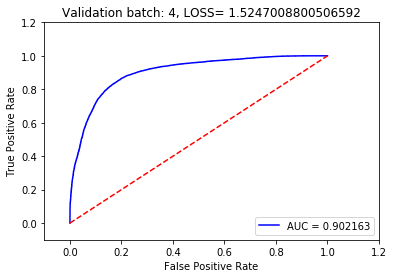

Validation batch: 5, LOSS=1.0012953281402588, ROC_AUC=0.9287510228343452 


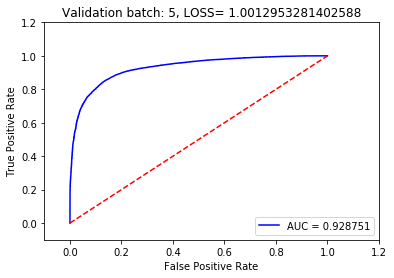

Validation batch: 6, LOSS=1.8922401666641235, ROC_AUC=0.8680451204160795 


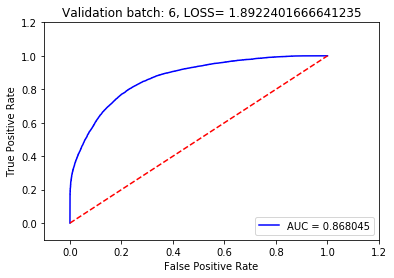

Validation batch: 7, LOSS=1.1853373050689697, ROC_AUC=0.910373080436945 


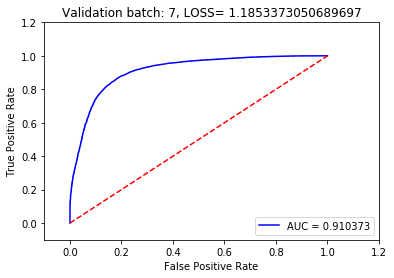

Validation batch: 8, LOSS=1.1093230247497559, ROC_AUC=0.9174099424482909 


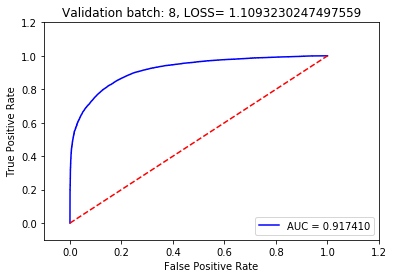

Validation batch: 9, LOSS=0.7303646206855774, ROC_AUC=0.9476711631877514 


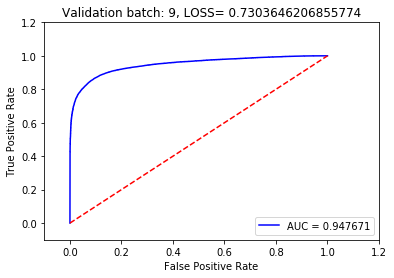

Validation batch: 10, LOSS=1.3027249574661255, ROC_AUC=0.895240456807981 


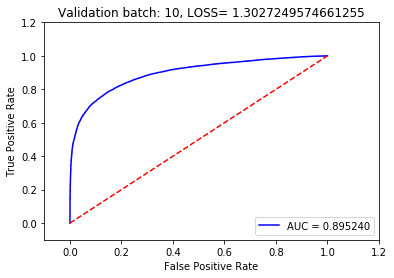

Validation batch: 11, LOSS=1.4923183917999268, ROC_AUC=0.8869360889829871 


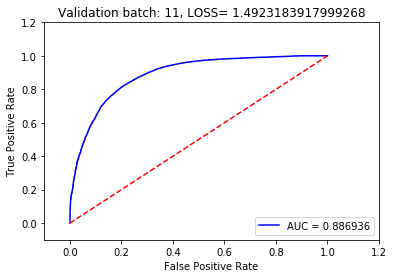

Validation batch: 12, LOSS=0.8493102192878723, ROC_AUC=0.949032207278087 


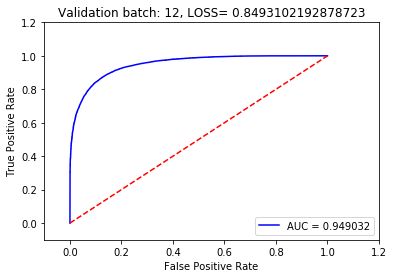

Validation batch: 13, LOSS=1.2689716815948486, ROC_AUC=0.9142279493310613 


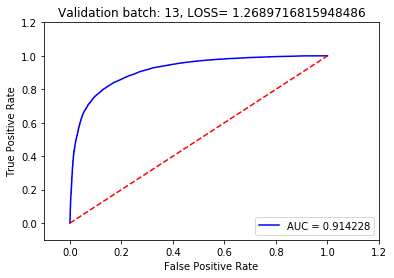

Validation batch: 14, LOSS=0.8828273415565491, ROC_AUC=0.9433997345279629 


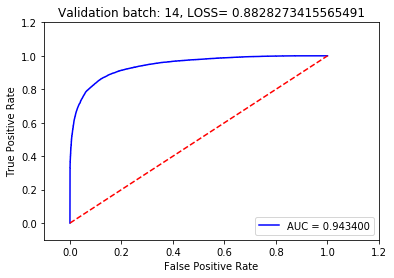

Validation batch: 15, LOSS=1.1414225101470947, ROC_AUC=0.9143505531920035 


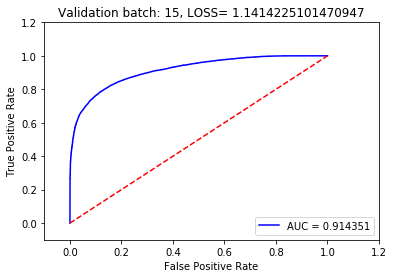

Validation batch: 16, LOSS=1.1697349548339844, ROC_AUC=0.9109816714086253 


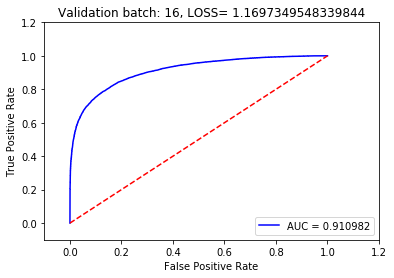

Validation batch: 17, LOSS=1.9698026180267334, ROC_AUC=0.8715621143047809 


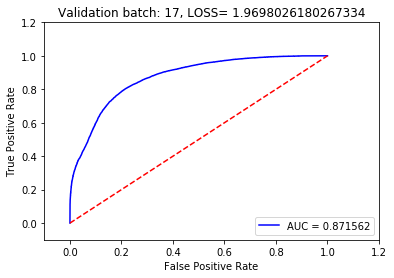

Validation batch: 18, LOSS=1.1946130990982056, ROC_AUC=0.9340436259484002 


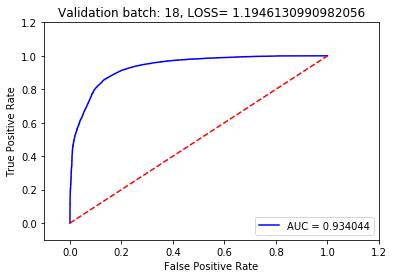

Validation batch: 19, LOSS=1.4429140090942383, ROC_AUC=0.8847726010643726 


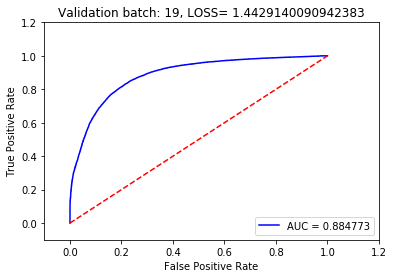

Validation batch: 20, LOSS=0.859827995300293, ROC_AUC=0.9453300643080399 


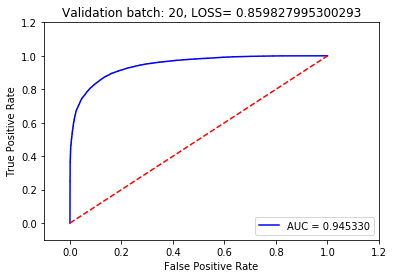

Validation batch: 21, LOSS=1.2978224754333496, ROC_AUC=0.8990110634775418 


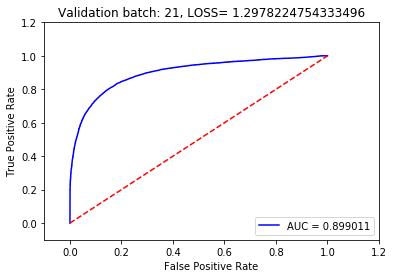

Validation batch: 22, LOSS=0.9221209287643433, ROC_AUC=0.940355692676621 


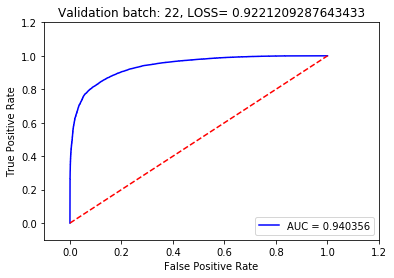

Validation batch: 23, LOSS=1.340043306350708, ROC_AUC=0.8820312021965477 


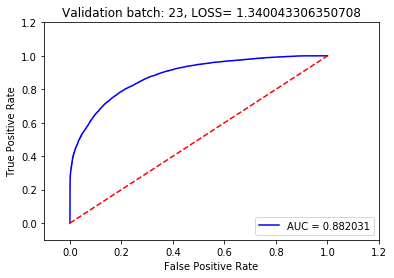

Validation batch: 24, LOSS=1.0189510583877563, ROC_AUC=0.9310616935016485 


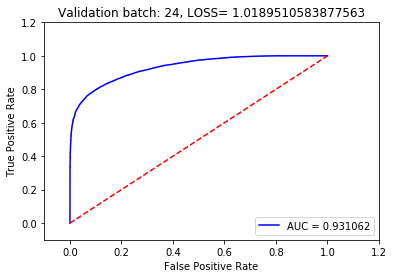

Validation batch: 25, LOSS=1.3405554294586182, ROC_AUC=0.9042508677421011 


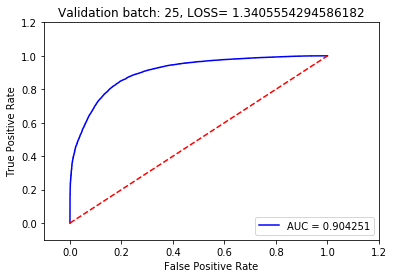

Validation batch: 26, LOSS=1.145829677581787, ROC_AUC=0.9114016470282681 


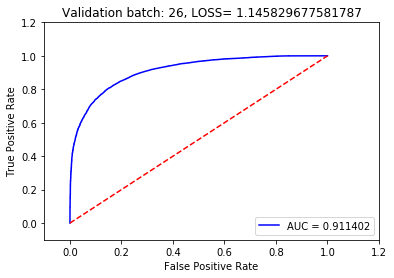

Validation batch: 27, LOSS=1.182573914527893, ROC_AUC=0.9059785313648232 


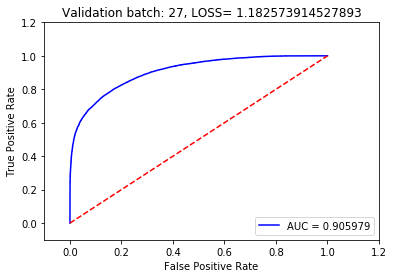

Validation batch: 28, LOSS=1.6221439838409424, ROC_AUC=0.849354282783582 


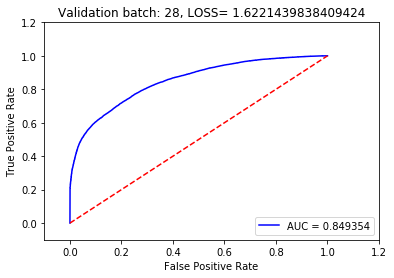

Validation batch: 29, LOSS=1.168006181716919, ROC_AUC=0.9151741740279536 


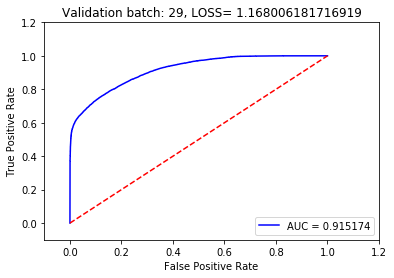

Validation batch: 30, LOSS=1.2559161186218262, ROC_AUC=0.903552045135823 


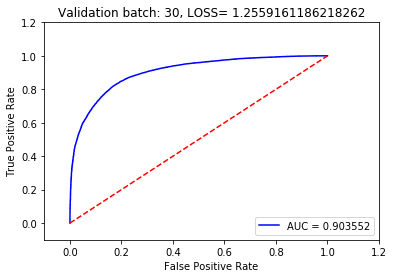

Validation batch: 31, LOSS=1.2587194442749023, ROC_AUC=0.9018169680307241 


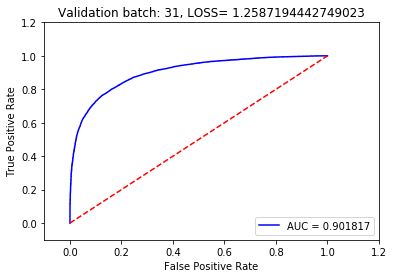

Validation batch: 32, LOSS=1.1321535110473633, ROC_AUC=0.9300006241265234 


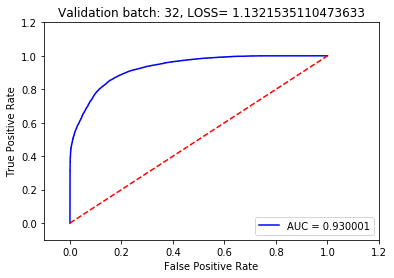

Validation batch: 33, LOSS=1.4440360069274902, ROC_AUC=0.8898438971811375 


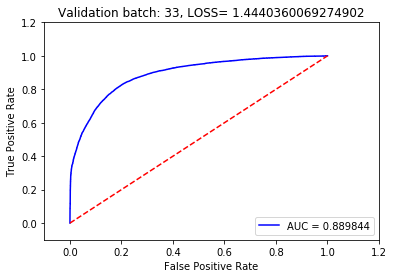

Validation batch: 34, LOSS=0.855238139629364, ROC_AUC=0.9348543365478459 


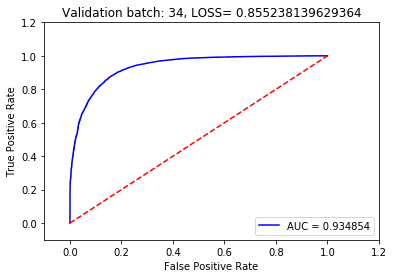

Validation batch: 35, LOSS=0.8832056522369385, ROC_AUC=0.934808302209832 


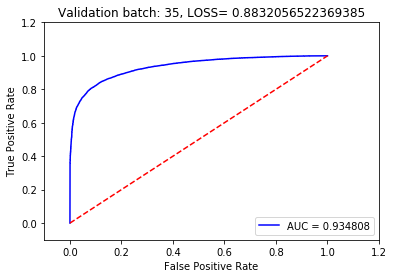

Validation batch: 36, LOSS=1.2782042026519775, ROC_AUC=0.9245053329588128 


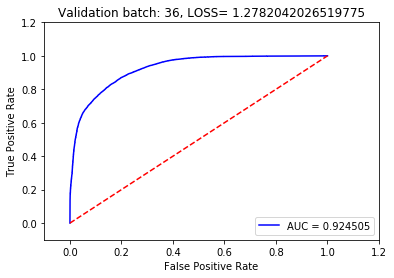

Validation batch: 37, LOSS=1.2259656190872192, ROC_AUC=0.9006085088362809 


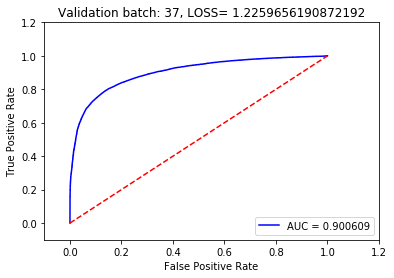

Validation batch: 38, LOSS=1.779818058013916, ROC_AUC=0.8623207822772776 


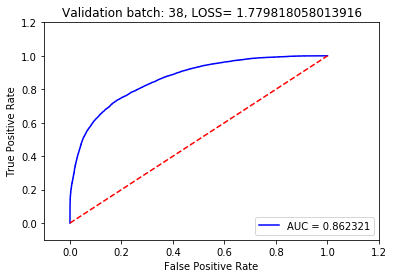

Validation batch: 39, LOSS=1.2058701515197754, ROC_AUC=0.9143154907507874 


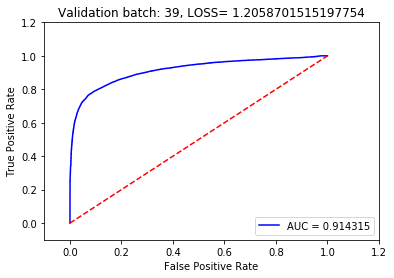

Validation batch: 40, LOSS=1.7539114952087402, ROC_AUC=0.829215299226467 


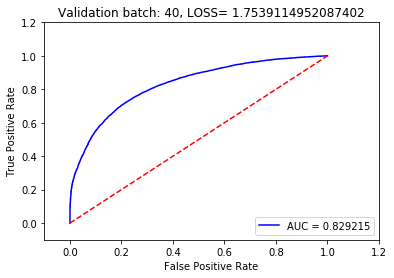

Validation batch: 41, LOSS=3.1007978916168213, ROC_AUC=0.8201418272028078 


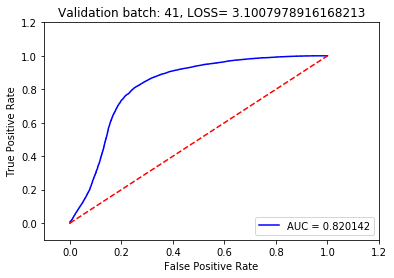

Validation batch: 42, LOSS=1.271207332611084, ROC_AUC=0.8755423031254053 


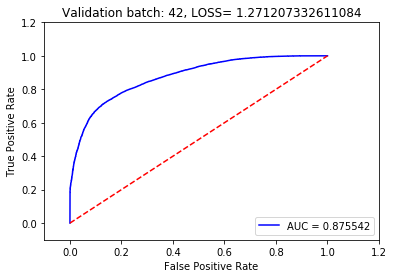

Validation batch: 43, LOSS=1.3083577156066895, ROC_AUC=0.8770210943949863 


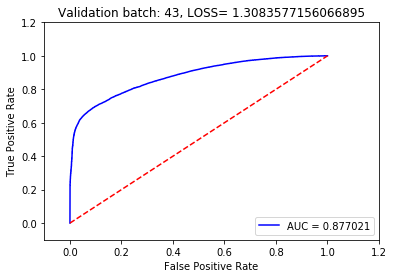

Validation batch: 44, LOSS=1.9761803150177002, ROC_AUC=0.8841855642616867 


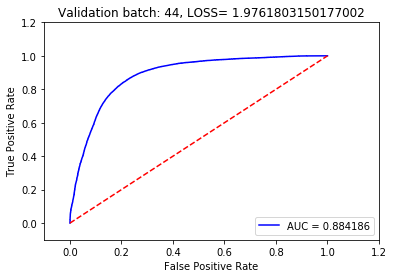

Validation batch: 45, LOSS=1.6476287841796875, ROC_AUC=0.8564214461369261 


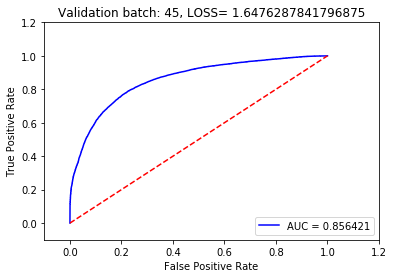

Validation batch: 46, LOSS=1.630570888519287, ROC_AUC=0.8578861286791604 


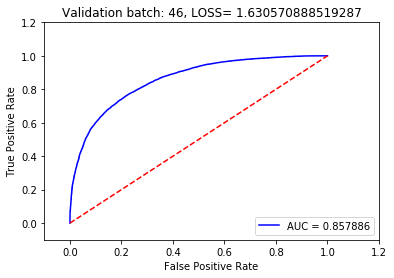

Validation batch: 47, LOSS=1.3471285104751587, ROC_AUC=0.8899020099230126 


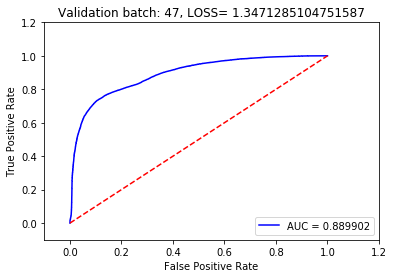

Validation batch: 48, LOSS=1.1368340253829956, ROC_AUC=0.9038826574192775 


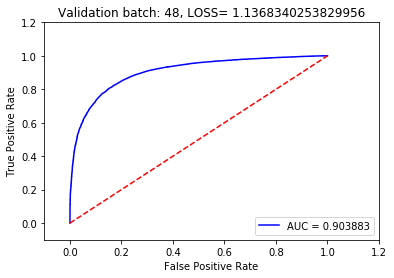

Validation batch: 49, LOSS=1.6977530717849731, ROC_AUC=0.8768693844613789 


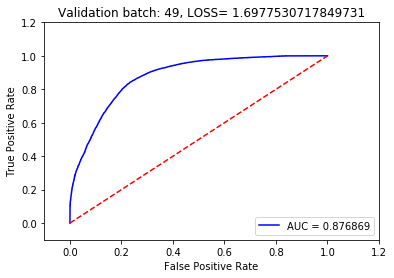

Validation batch: 50, LOSS=1.4564361572265625, ROC_AUC=0.8869846789195222 


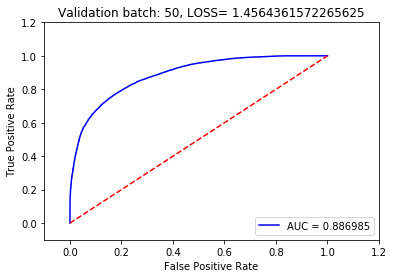

Validation batch: 51, LOSS=1.961958408355713, ROC_AUC=0.8581843267783335 


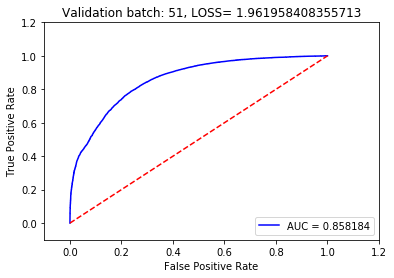

Validation batch: 52, LOSS=1.187861680984497, ROC_AUC=0.9310340456357846 


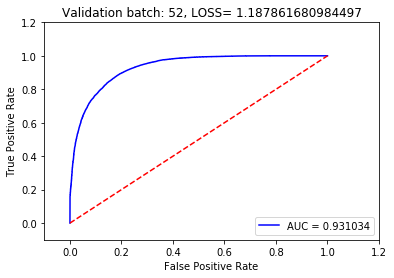

Validation batch: 53, LOSS=1.305160641670227, ROC_AUC=0.8831520023340967 


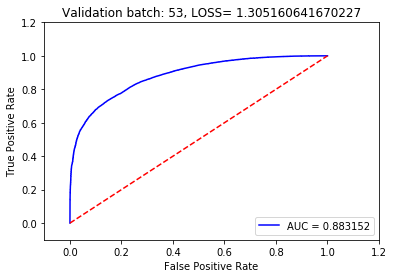

Validation batch: 54, LOSS=1.5456273555755615, ROC_AUC=0.8474526893588353 


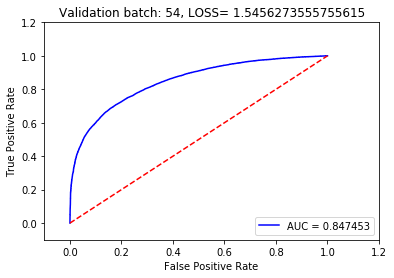

Validation batch: 55, LOSS=1.79392671585083, ROC_AUC=0.8667950425224288 


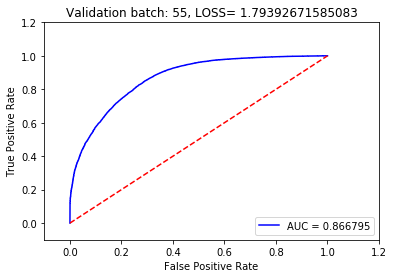

Validation batch: 56, LOSS=1.5947637557983398, ROC_AUC=0.8431975706395368 


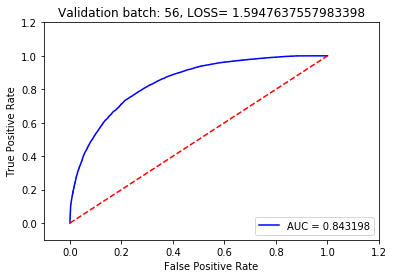

Validation batch: 57, LOSS=0.8090758323669434, ROC_AUC=0.9576859683711151 


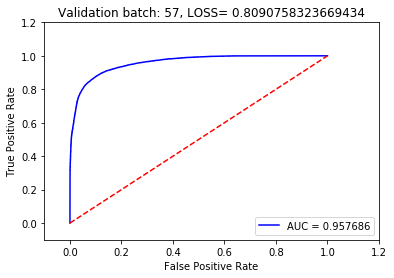

Validation batch: 58, LOSS=1.4035329818725586, ROC_AUC=0.8461842807013931 


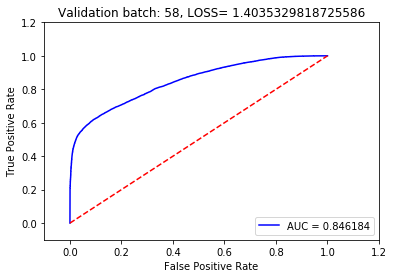

Validation batch: 59, LOSS=1.3165900707244873, ROC_AUC=0.9096501447975025 


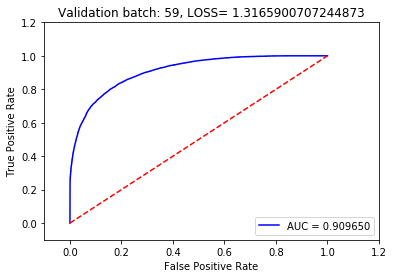

Validation batch: 60, LOSS=1.696413278579712, ROC_AUC=0.8649834082907031 


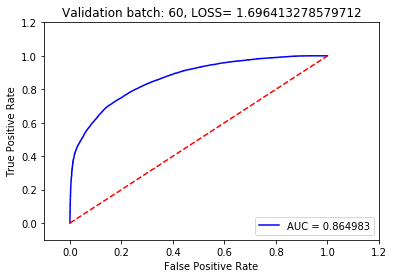

Validation batch: 61, LOSS=0.8371298313140869, ROC_AUC=0.9432175985535997 


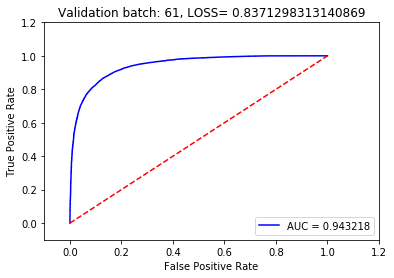

Validation batch: 62, LOSS=1.1308355331420898, ROC_AUC=0.9075810367820173 


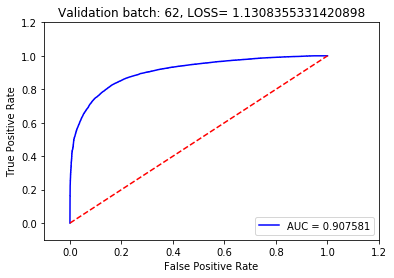

Validation batch: 63, LOSS=1.1484781503677368, ROC_AUC=0.9067493667217991 


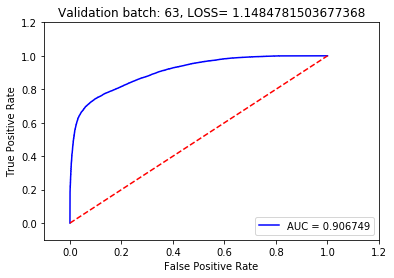

Validation batch: 64, LOSS=1.3385217189788818, ROC_AUC=0.884334488168738 


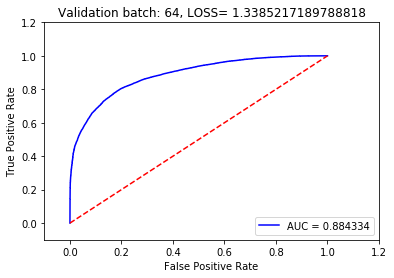

Validation batch: 65, LOSS=1.1375291347503662, ROC_AUC=0.9055793060817616 


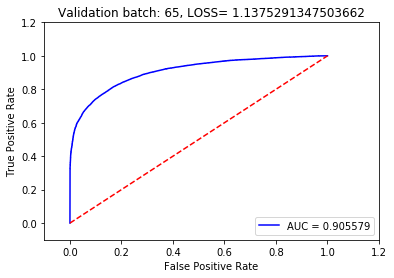

Validation batch: 66, LOSS=1.8007290363311768, ROC_AUC=0.8536190227649665 


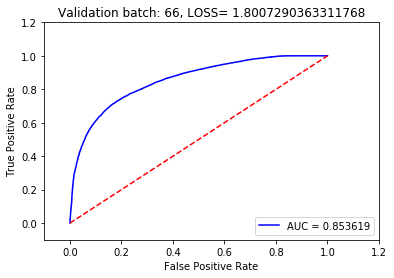

Validation batch: 67, LOSS=2.2989306449890137, ROC_AUC=0.8581755674895305 


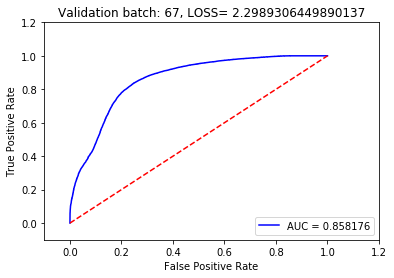

Validation batch: 68, LOSS=1.5193798542022705, ROC_AUC=0.8524155159986553 


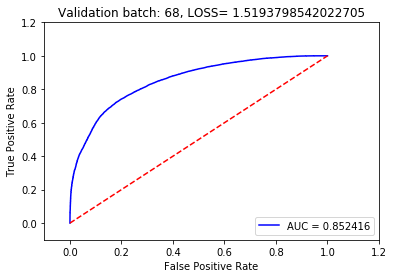

Validation batch: 69, LOSS=1.0662192106246948, ROC_AUC=0.9194867469791788 


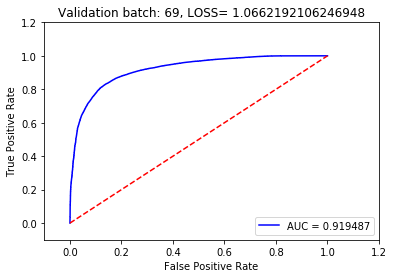

Validation batch: 70, LOSS=1.8285735845565796, ROC_AUC=0.8239415682148592 


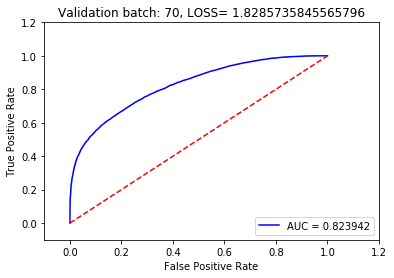

Validation batch: 71, LOSS=1.3762061595916748, ROC_AUC=0.8729285725473186 


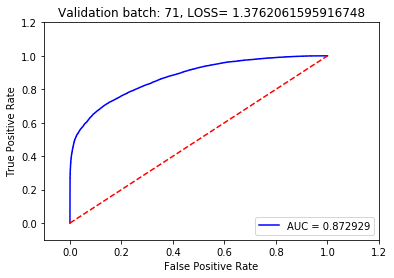

Validation batch: 72, LOSS=1.5354031324386597, ROC_AUC=0.8823416915138517 


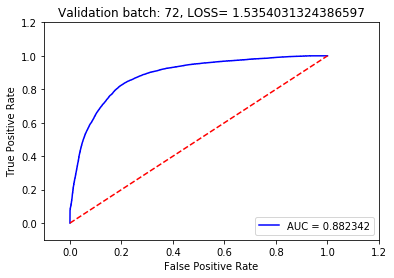

Validation batch: 73, LOSS=1.9427294731140137, ROC_AUC=0.8237950171887738 


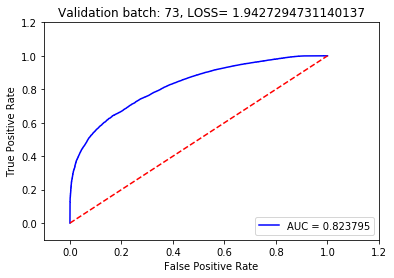

Validation batch: 74, LOSS=1.5169161558151245, ROC_AUC=0.8835833845589134 


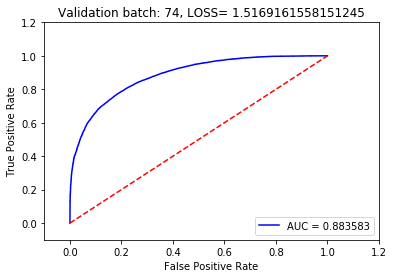

Validation batch: 75, LOSS=1.4958715438842773, ROC_AUC=0.8619387407085914 


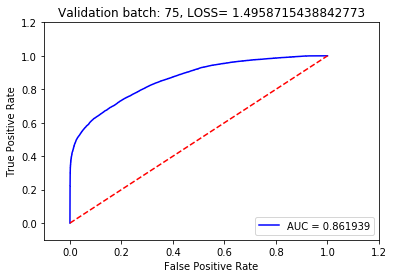

Validation batch: 76, LOSS=2.2873597145080566, ROC_AUC=0.7717695134132521 


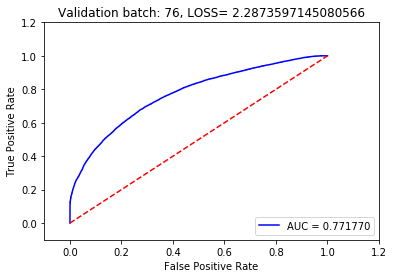

Validation batch: 77, LOSS=1.24925696849823, ROC_AUC=0.872267842980156 


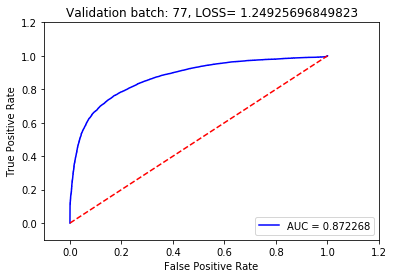

Validation batch: 78, LOSS=1.4817895889282227, ROC_AUC=0.8698529931593189 


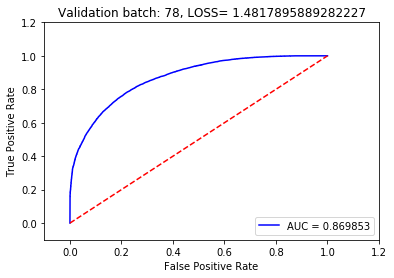

Validation batch: 79, LOSS=2.201680898666382, ROC_AUC=0.8030316845696086 


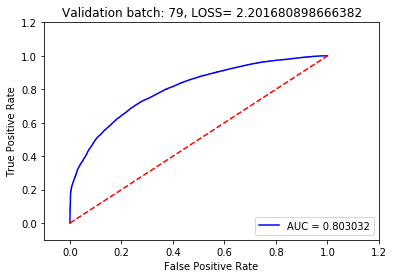

Validation batch: 80, LOSS=2.224520683288574, ROC_AUC=0.810893554596358 


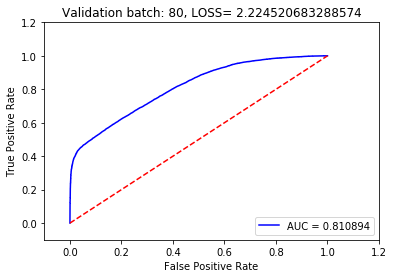

Validation batch: 81, LOSS=2.2417221069335938, ROC_AUC=0.8266426880335769 


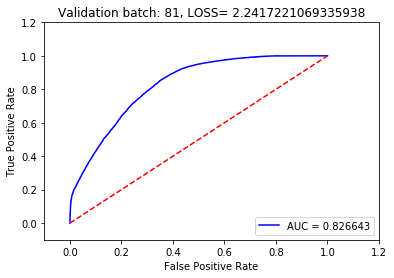

Validation batch: 82, LOSS=1.3543554544448853, ROC_AUC=0.8827542206346015 


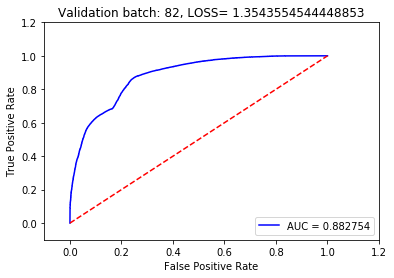

Validation batch: 83, LOSS=1.6251380443572998, ROC_AUC=0.8726336446447334 


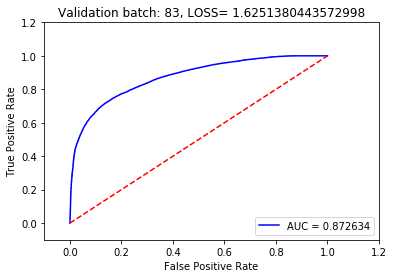

Validation batch: 84, LOSS=0.841558575630188, ROC_AUC=0.9394383810989169 


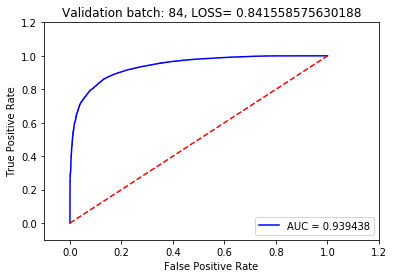

Validation batch: 85, LOSS=1.5313911437988281, ROC_AUC=0.8452496859615853 


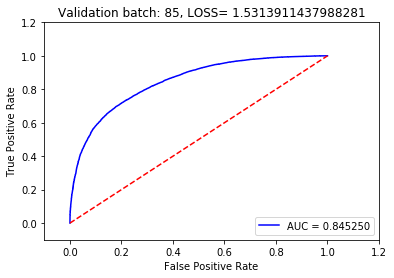

Validation batch: 86, LOSS=1.348483681678772, ROC_AUC=0.8469633997677644 


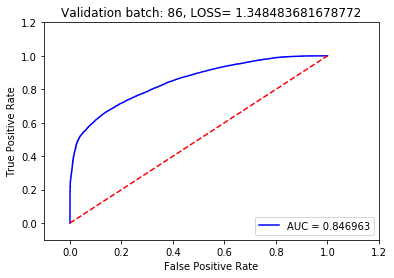

Validation batch: 87, LOSS=2.552440643310547, ROC_AUC=0.831414955124032 


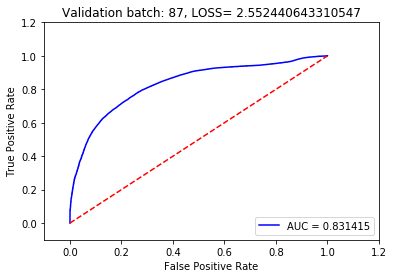

Validation batch: 88, LOSS=1.597882628440857, ROC_AUC=0.8541998953664538 


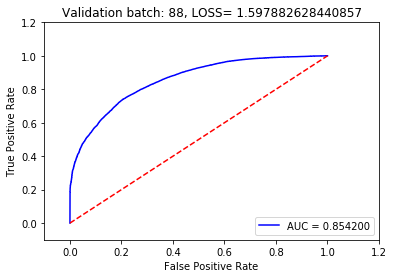

Validation batch: 89, LOSS=1.6863172054290771, ROC_AUC=0.8620910756063118 


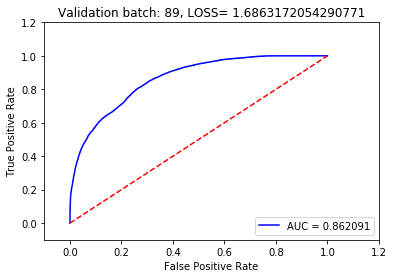

Validation batch: 90, LOSS=2.038411855697632, ROC_AUC=0.806253995370865 


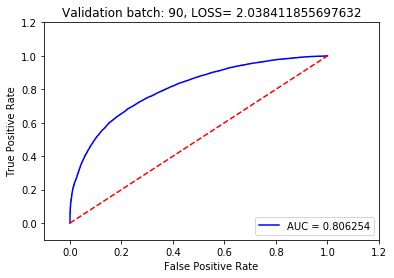

Validation batch: 91, LOSS=1.218205451965332, ROC_AUC=0.8728383657867382 


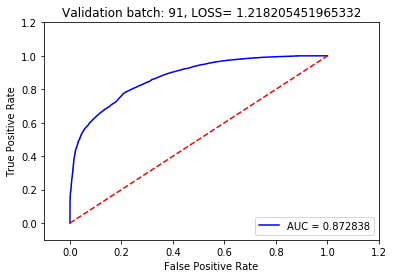

Validation batch: 92, LOSS=1.4220962524414062, ROC_AUC=0.8634992874973388 


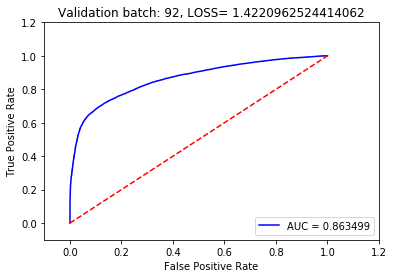

Validation batch: 93, LOSS=1.9948997497558594, ROC_AUC=0.7728445708590688 


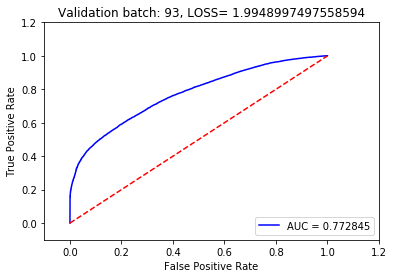

Validation batch: 94, LOSS=1.7747769355773926, ROC_AUC=0.8205144456441311 


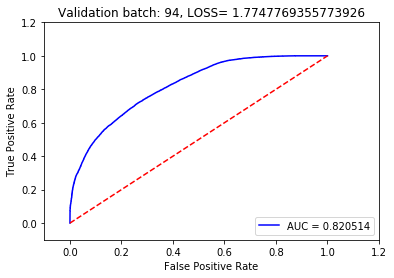

Validation batch: 95, LOSS=1.3894386291503906, ROC_AUC=0.8592243121221445 


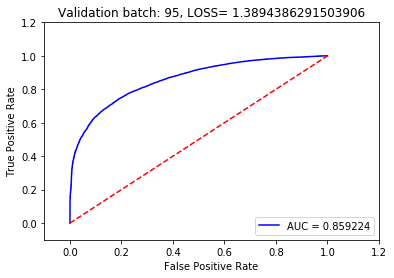

Validation batch: 96, LOSS=1.5749762058258057, ROC_AUC=0.8385350067409477 


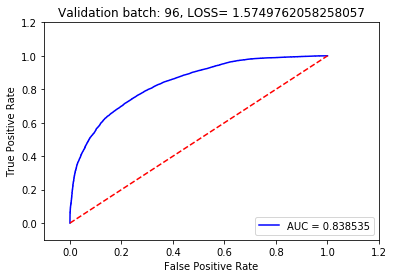

Validation batch: 97, LOSS=1.306847095489502, ROC_AUC=0.9004717040238573 


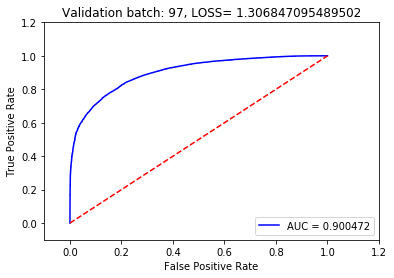

Validation batch: 98, LOSS=1.7596133947372437, ROC_AUC=0.8298175615947434 


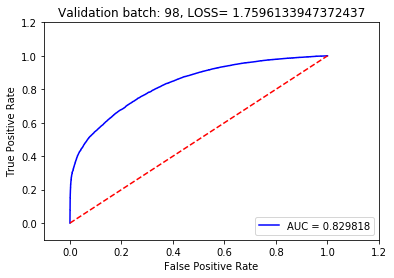

Validation batch: 99, LOSS=1.7165992259979248, ROC_AUC=0.8783671147393647 


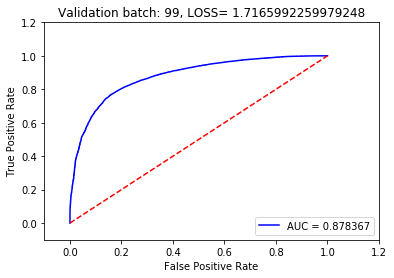

Validation batch: 100, LOSS=1.8093706369400024, ROC_AUC=0.7970215882927003 


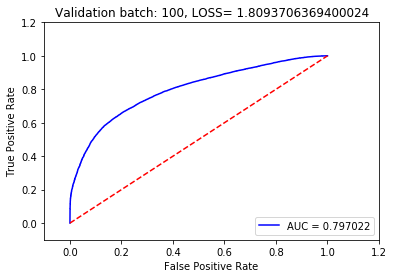

Validation batch: 101, LOSS=1.211594820022583, ROC_AUC=0.9188750226886975 


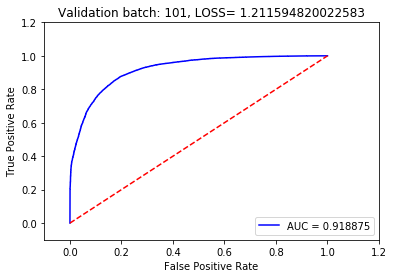

Validation batch: 102, LOSS=1.6177247762680054, ROC_AUC=0.8633783519990827 


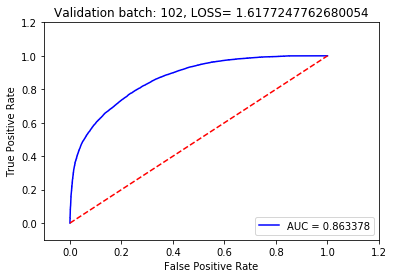

Validation batch: 103, LOSS=1.2419180870056152, ROC_AUC=0.9037416329876701 


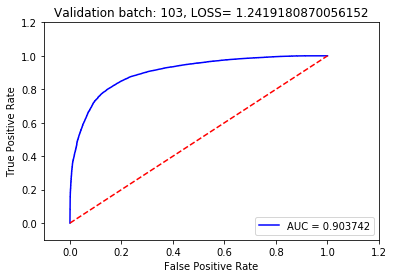

Validation batch: 104, LOSS=1.6698209047317505, ROC_AUC=0.853849172712716 


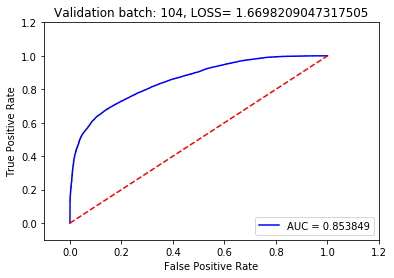

Validation batch: 105, LOSS=1.9393284320831299, ROC_AUC=0.826102312684519 


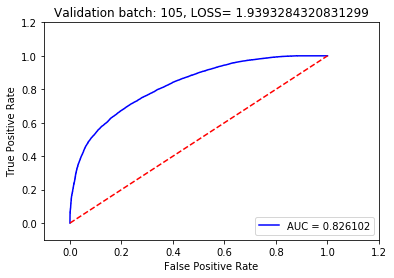

Validation batch: 106, LOSS=2.1056628227233887, ROC_AUC=0.7926848707633998 


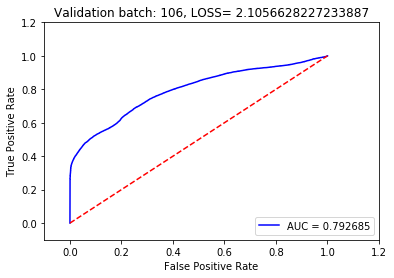

Validation batch: 107, LOSS=1.2144454717636108, ROC_AUC=0.8859008379044115 


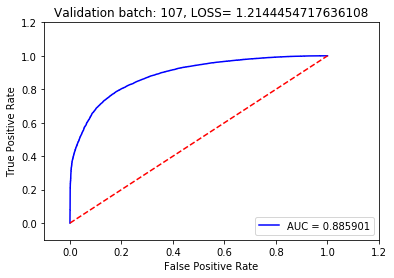

Validation batch: 108, LOSS=1.4954665899276733, ROC_AUC=0.8605429802556364 


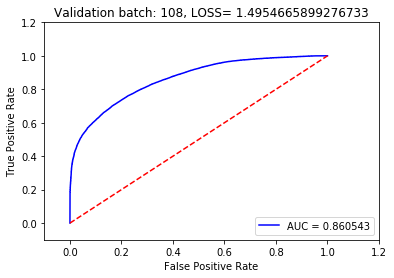

Validation batch: 109, LOSS=1.8933806419372559, ROC_AUC=0.8094560108974918 


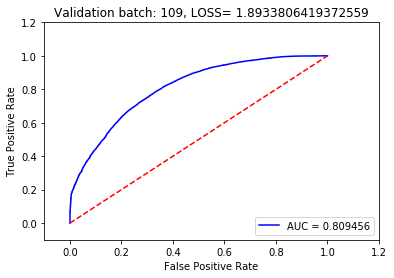

Validation batch: 110, LOSS=1.1806143522262573, ROC_AUC=0.9037402835083908 


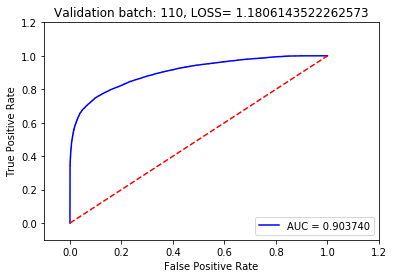

Validation batch: 111, LOSS=1.7084760665893555, ROC_AUC=0.8715898479023012 


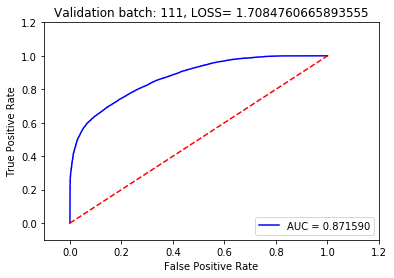

Validation batch: 112, LOSS=1.657728672027588, ROC_AUC=0.8472327730910257 


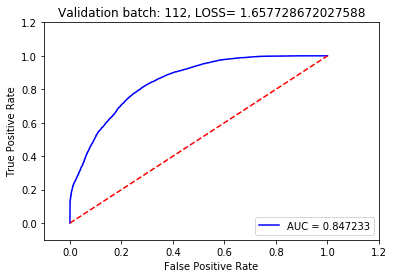

Validation batch: 113, LOSS=1.8527462482452393, ROC_AUC=0.836525841993158 


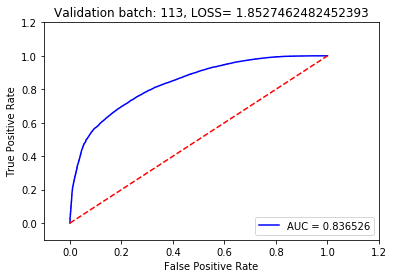

Validation batch: 114, LOSS=1.2205629348754883, ROC_AUC=0.8926480748176209 


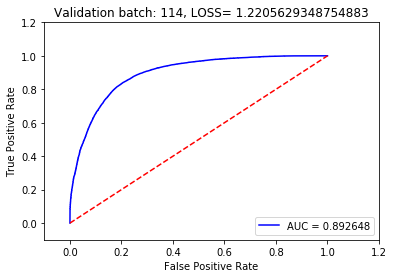

Validation batch: 115, LOSS=1.6985464096069336, ROC_AUC=0.8438691571698884 


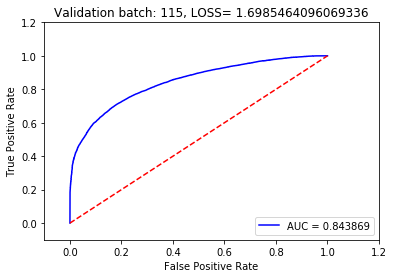

Validation batch: 116, LOSS=1.034500002861023, ROC_AUC=0.9172701564240595 


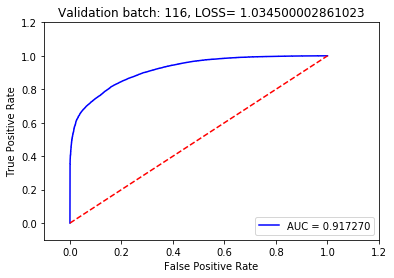

Validation batch: 117, LOSS=1.2440853118896484, ROC_AUC=0.890391395773694 


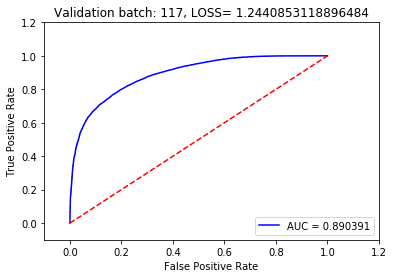

Validation batch: 118, LOSS=1.3103158473968506, ROC_AUC=0.8980074084888467 


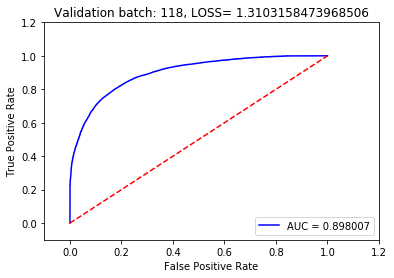

Validation batch: 119, LOSS=1.3357064723968506, ROC_AUC=0.8644312875818898 


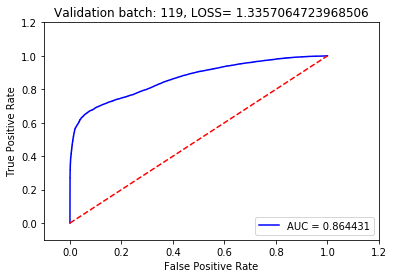

Validation batch: 120, LOSS=0.9959256649017334, ROC_AUC=0.9126858582741482 


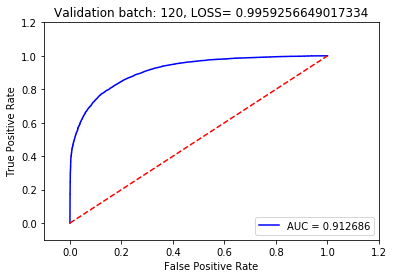

Validation batch: 121, LOSS=2.1614065170288086, ROC_AUC=0.8065202384880176 


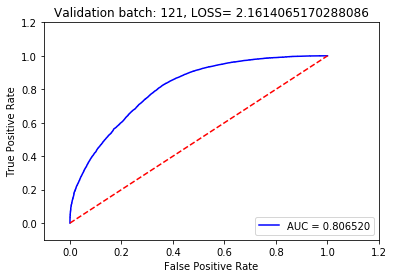

Validation batch: 122, LOSS=1.6710667610168457, ROC_AUC=0.8913883929252259 


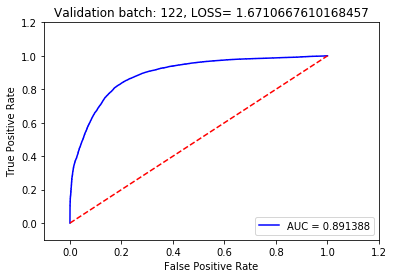

Validation batch: 123, LOSS=1.4167622327804565, ROC_AUC=0.875393991571433 


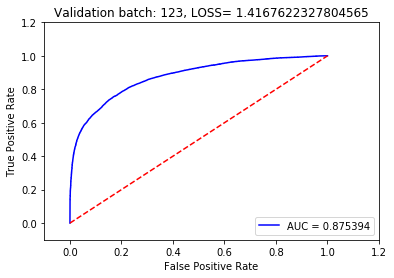

Validation batch: 124, LOSS=1.3625972270965576, ROC_AUC=0.8799397298017015 


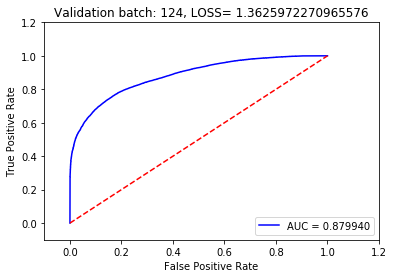

In [22]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





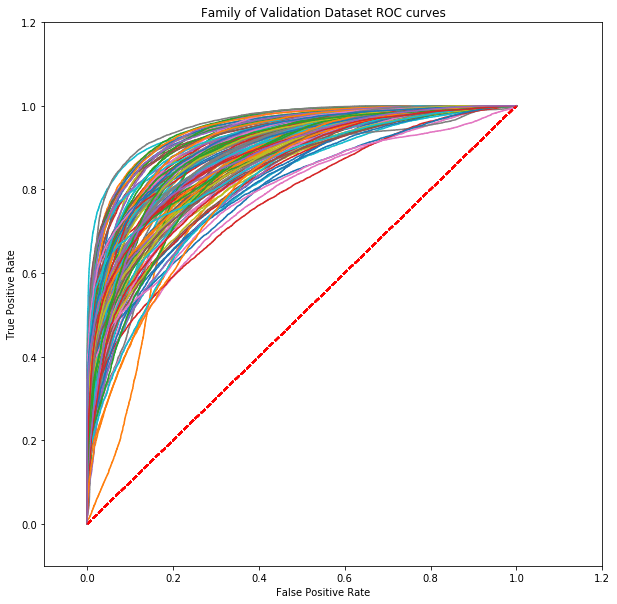

In [23]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

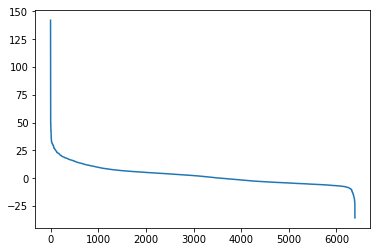

In [24]:
plt.plot(all_thresh[0])

In [25]:
model_path = 'runs/debug/MS2_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

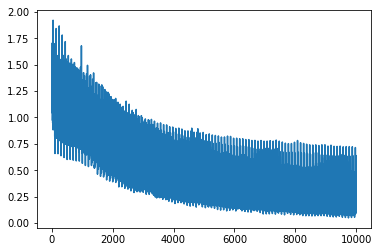

In [26]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


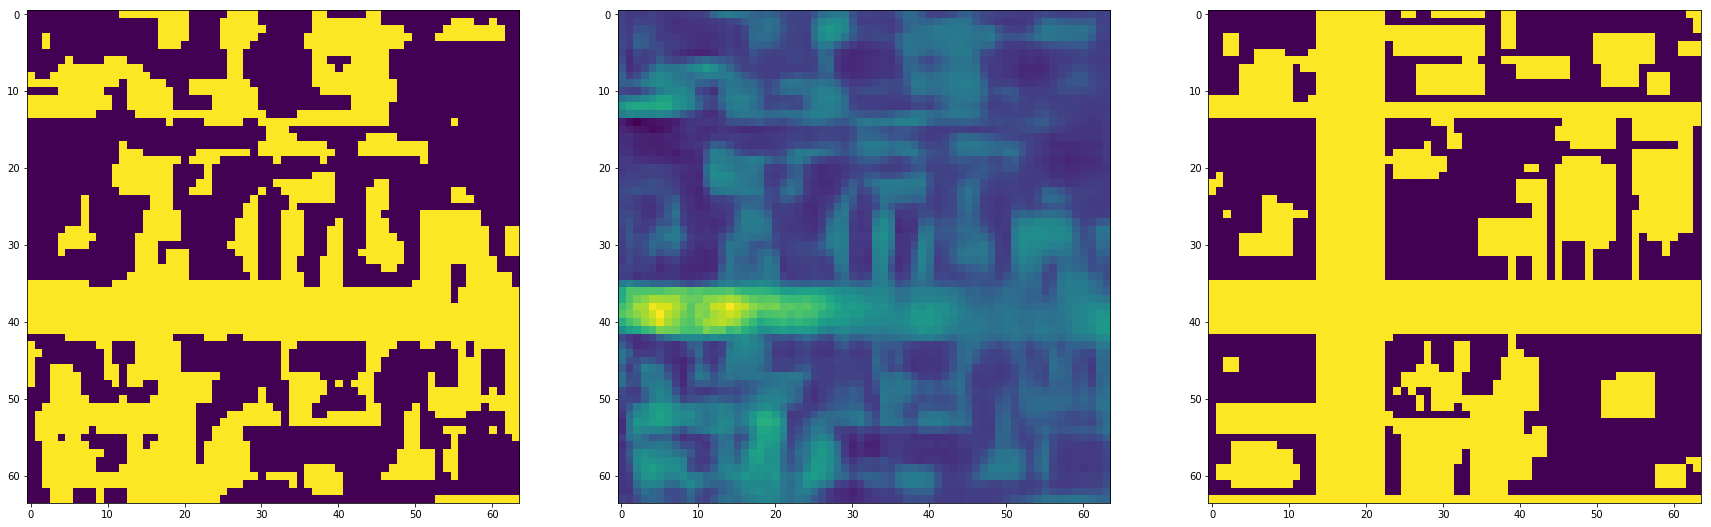

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


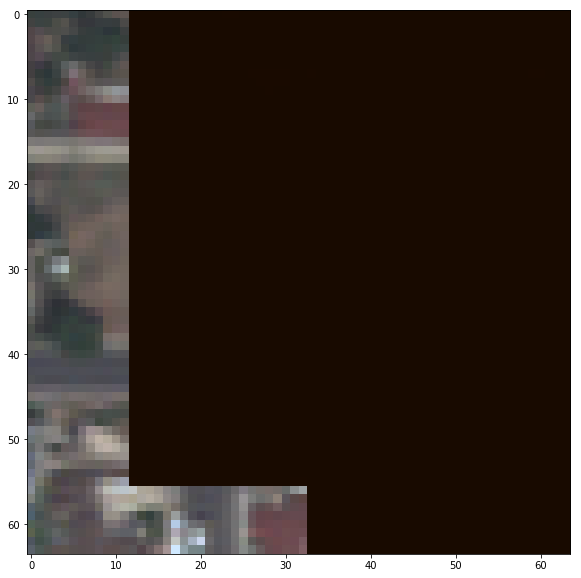

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


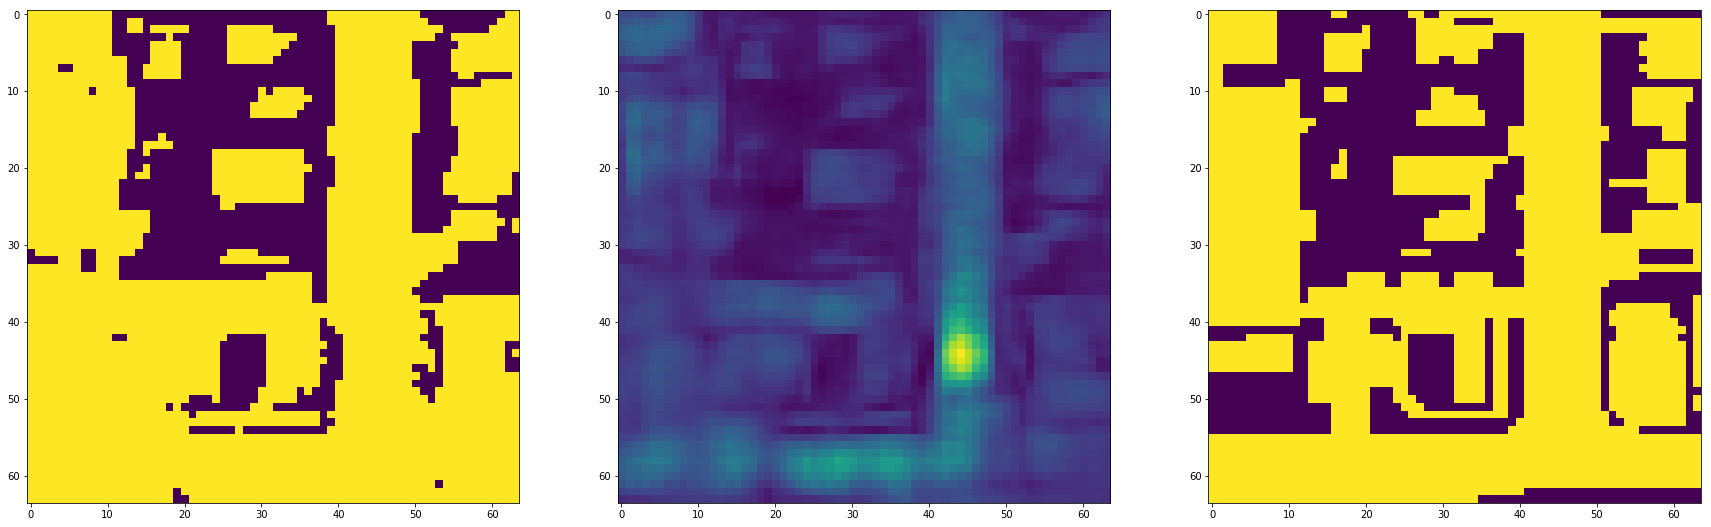

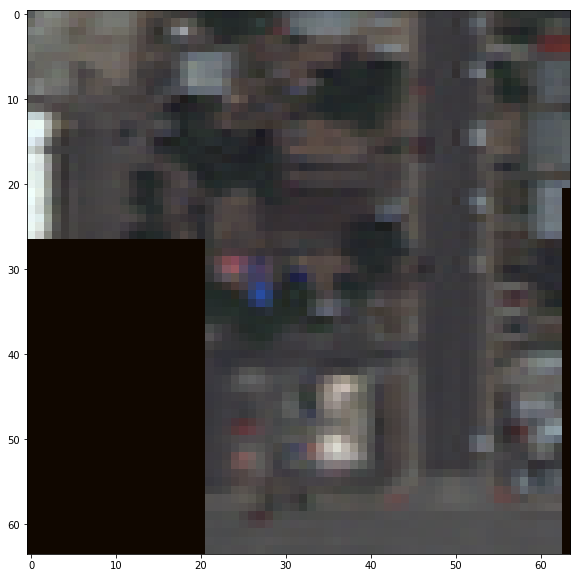

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


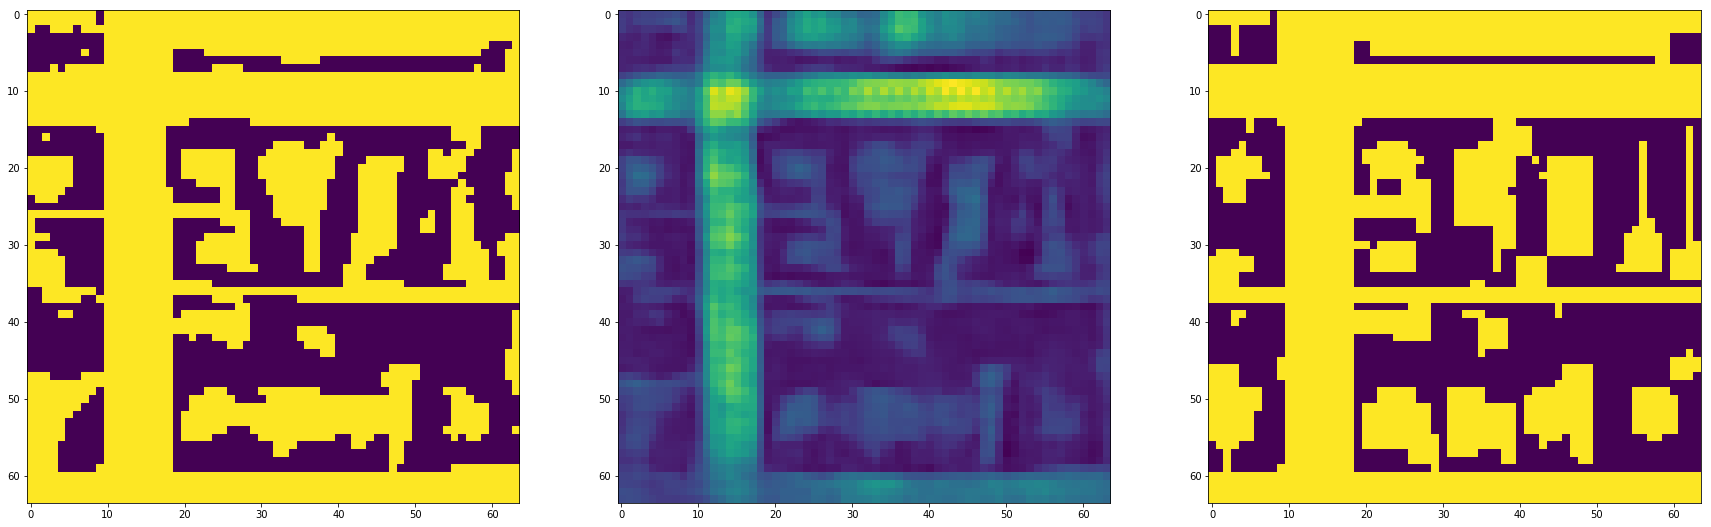

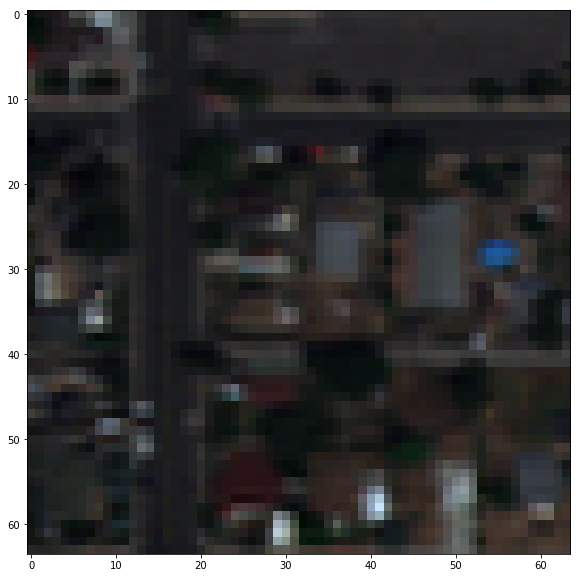

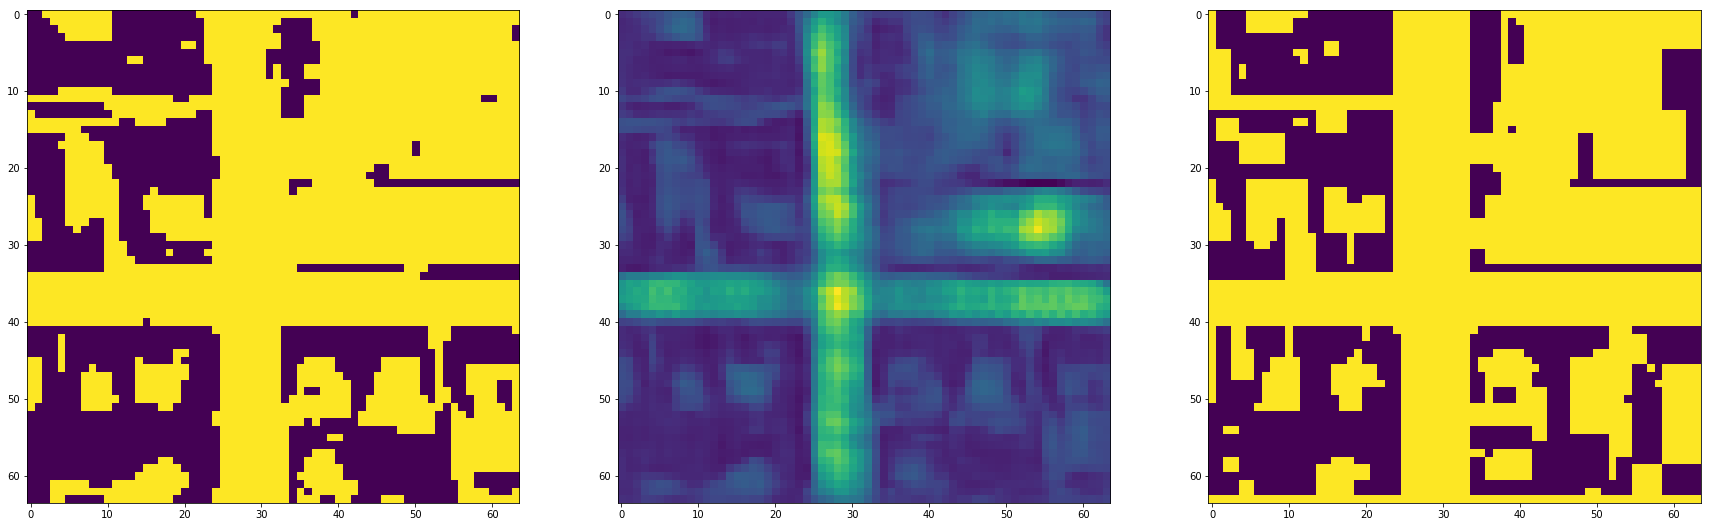

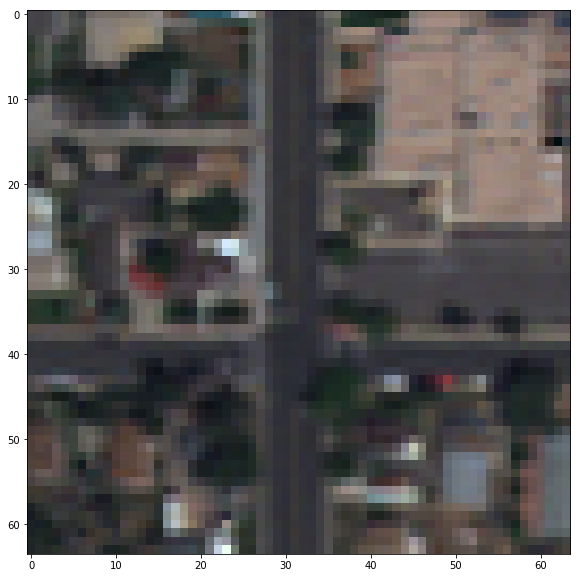

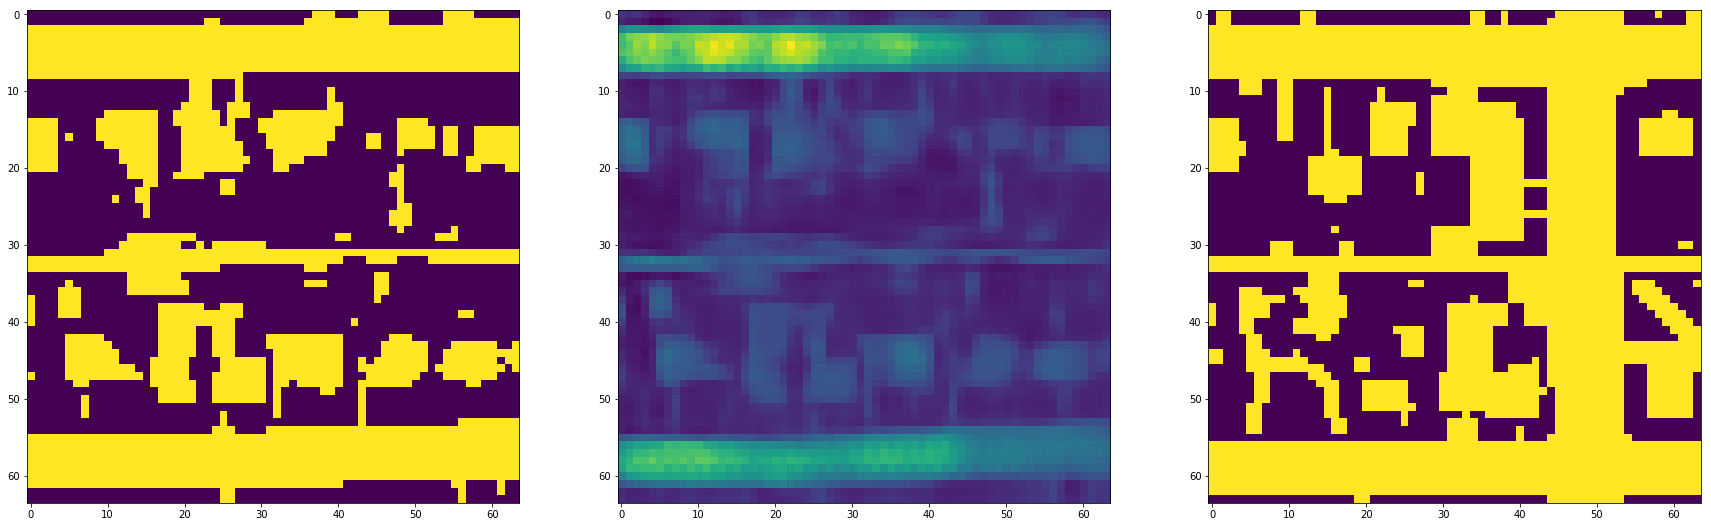

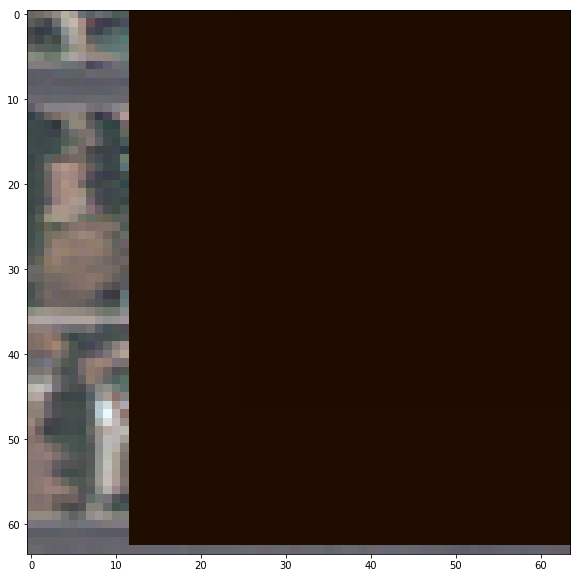

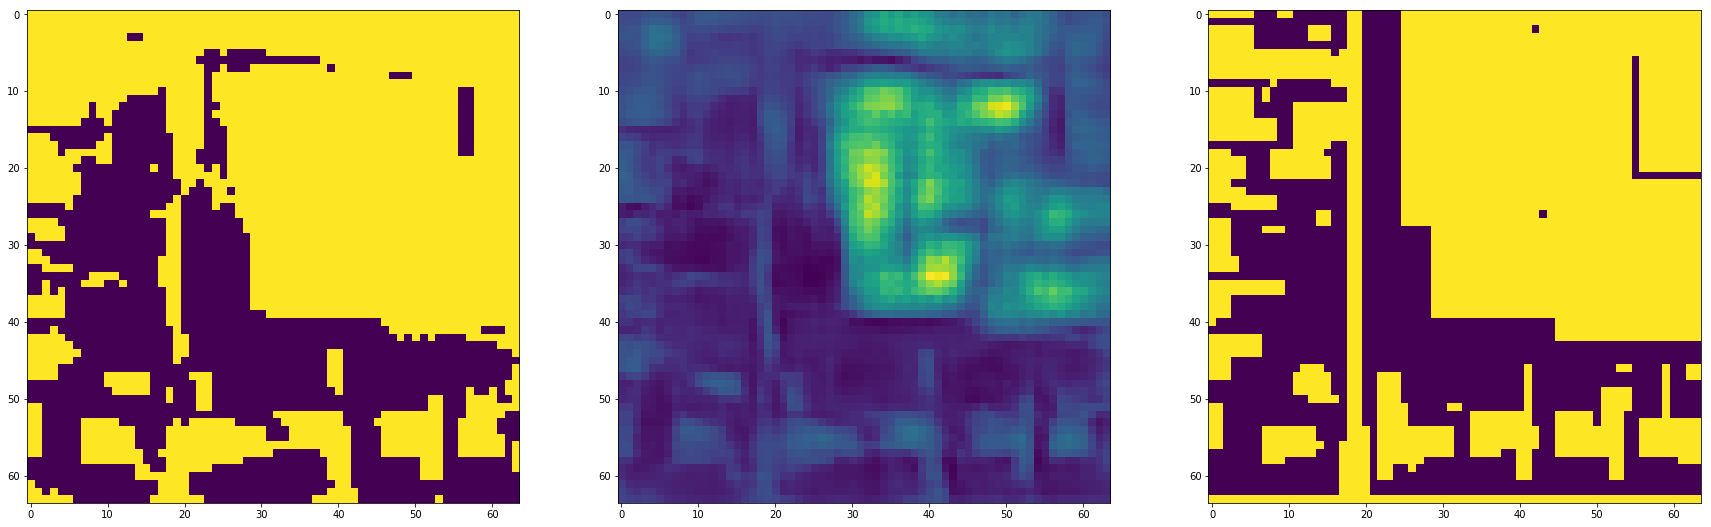

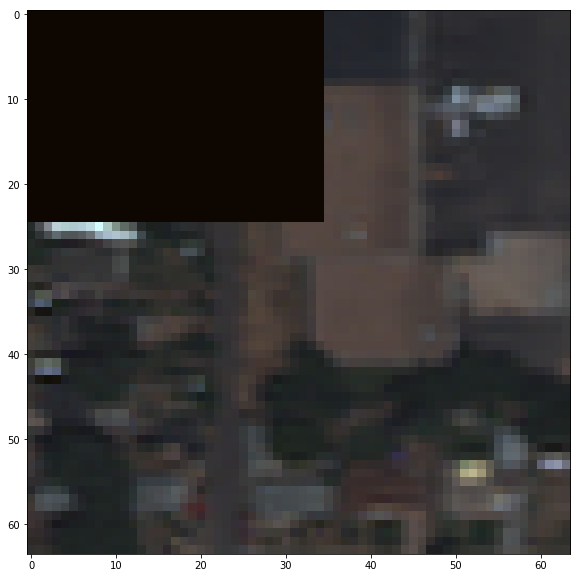

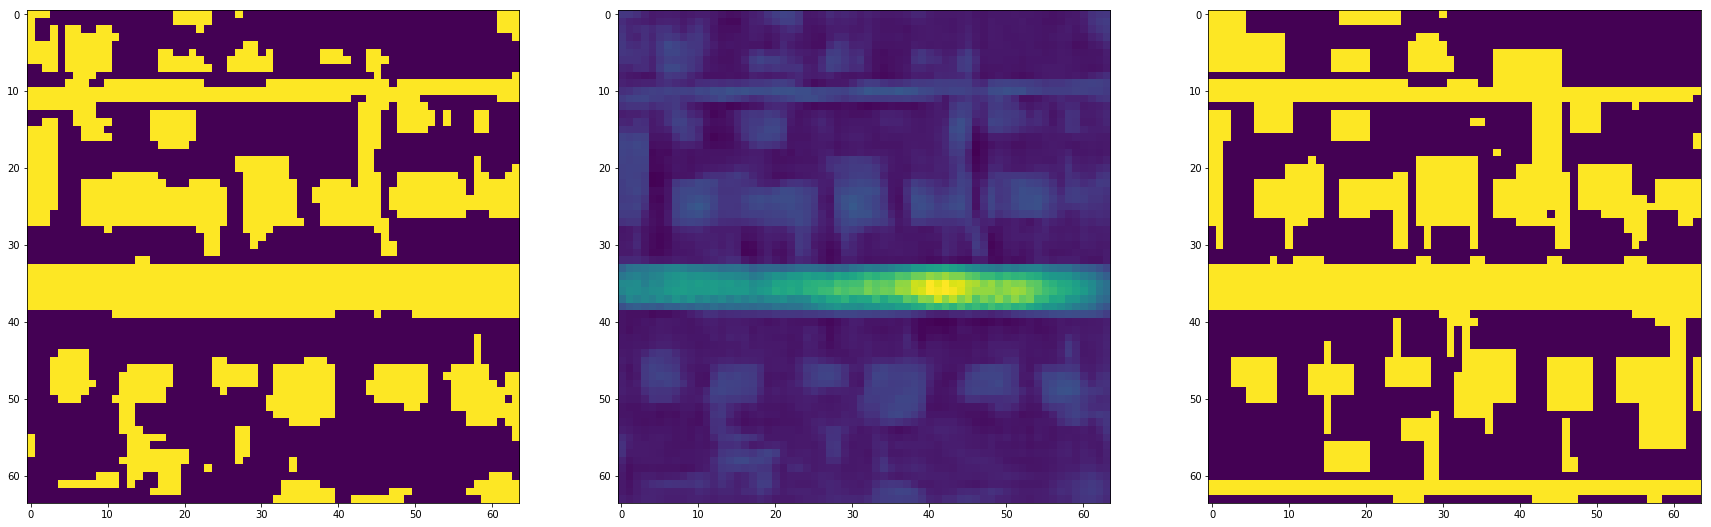

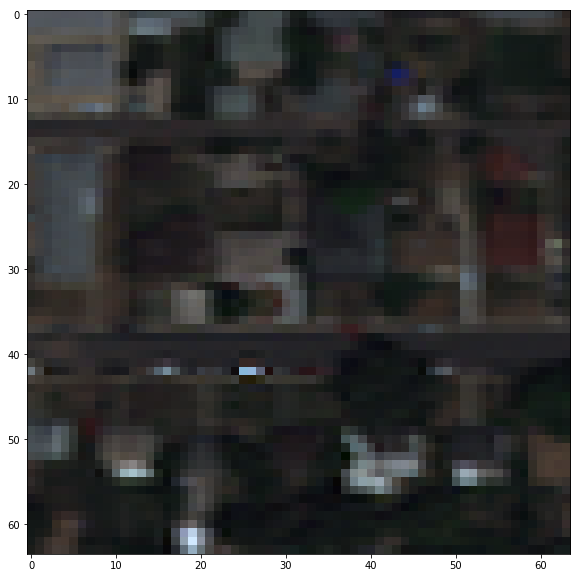

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


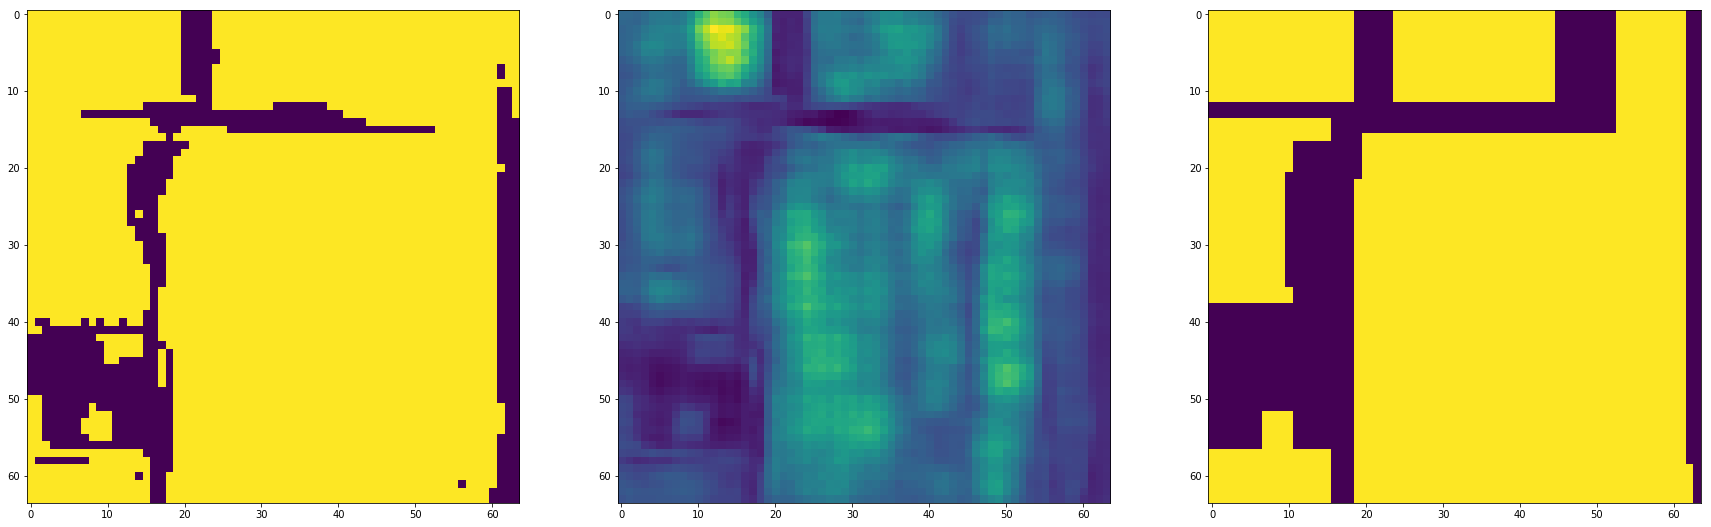

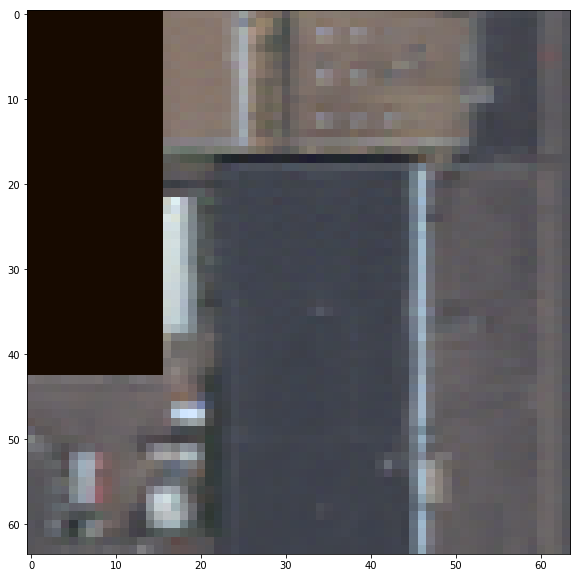

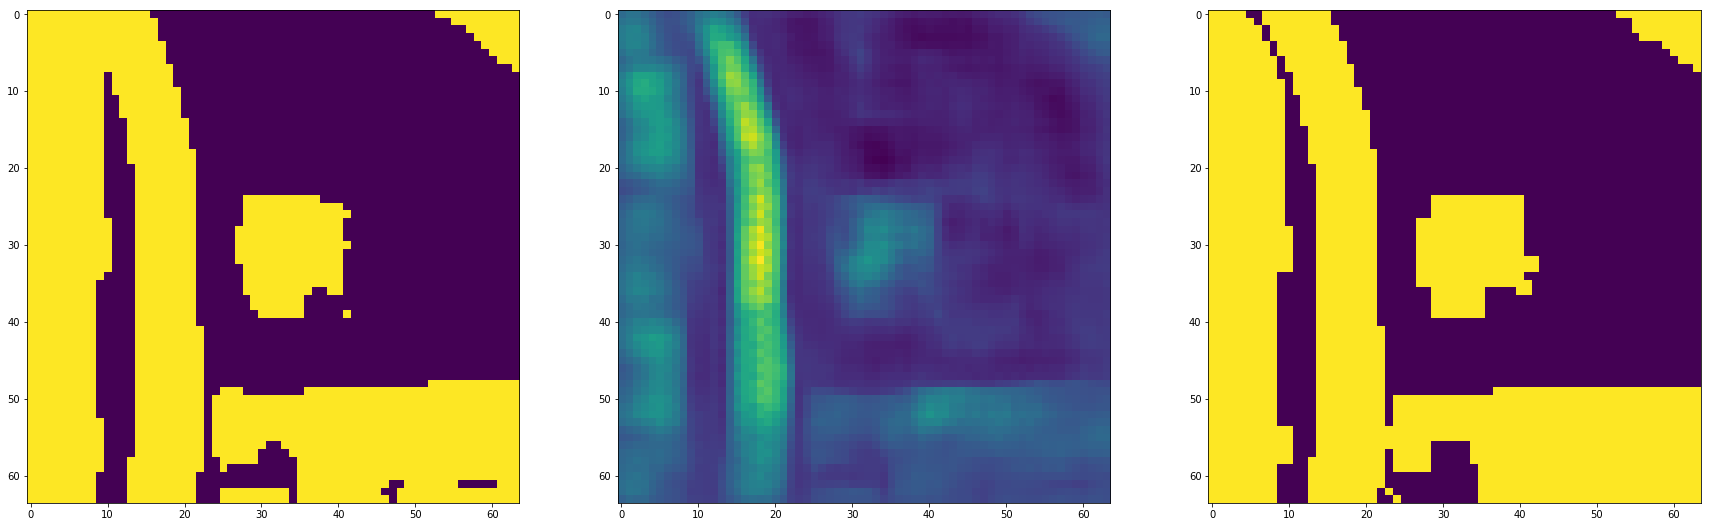

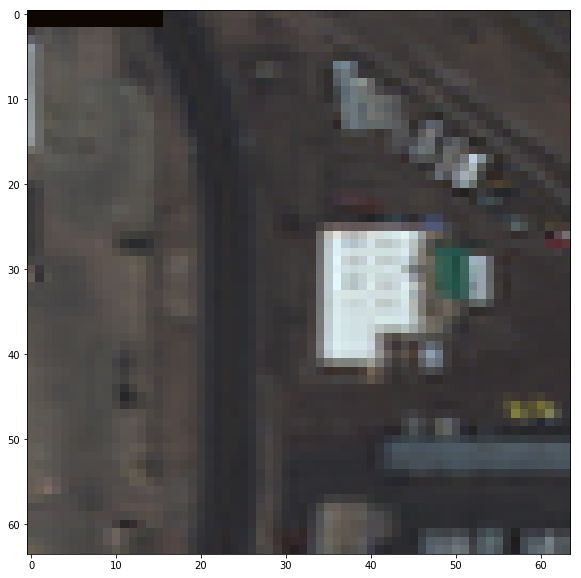

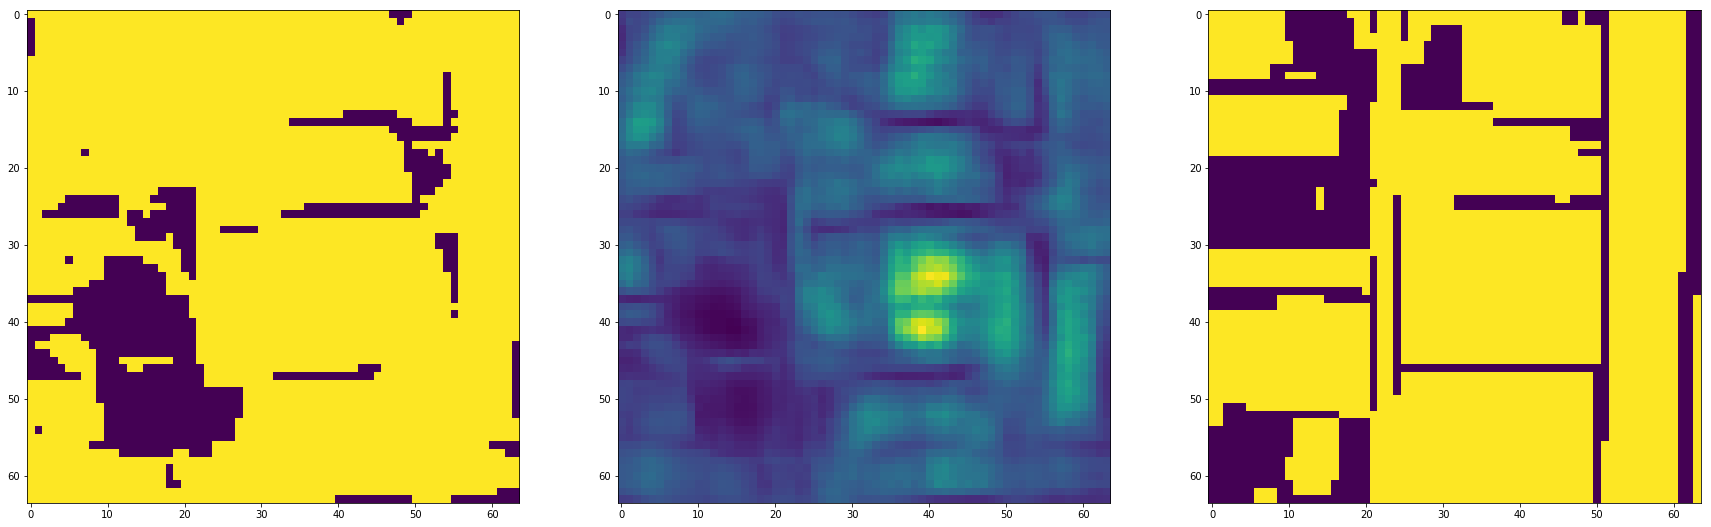

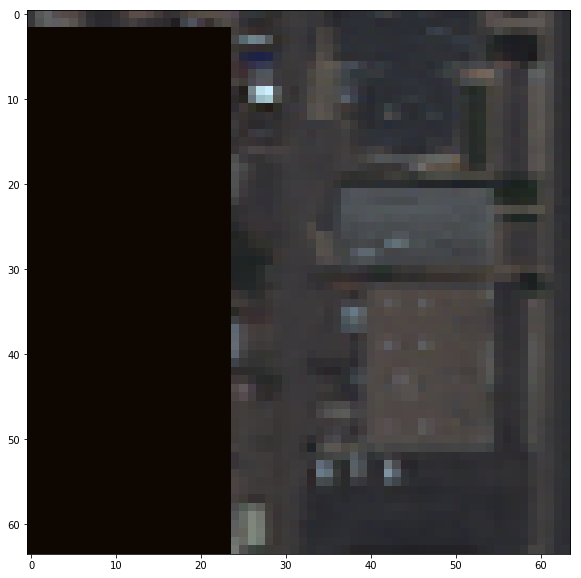

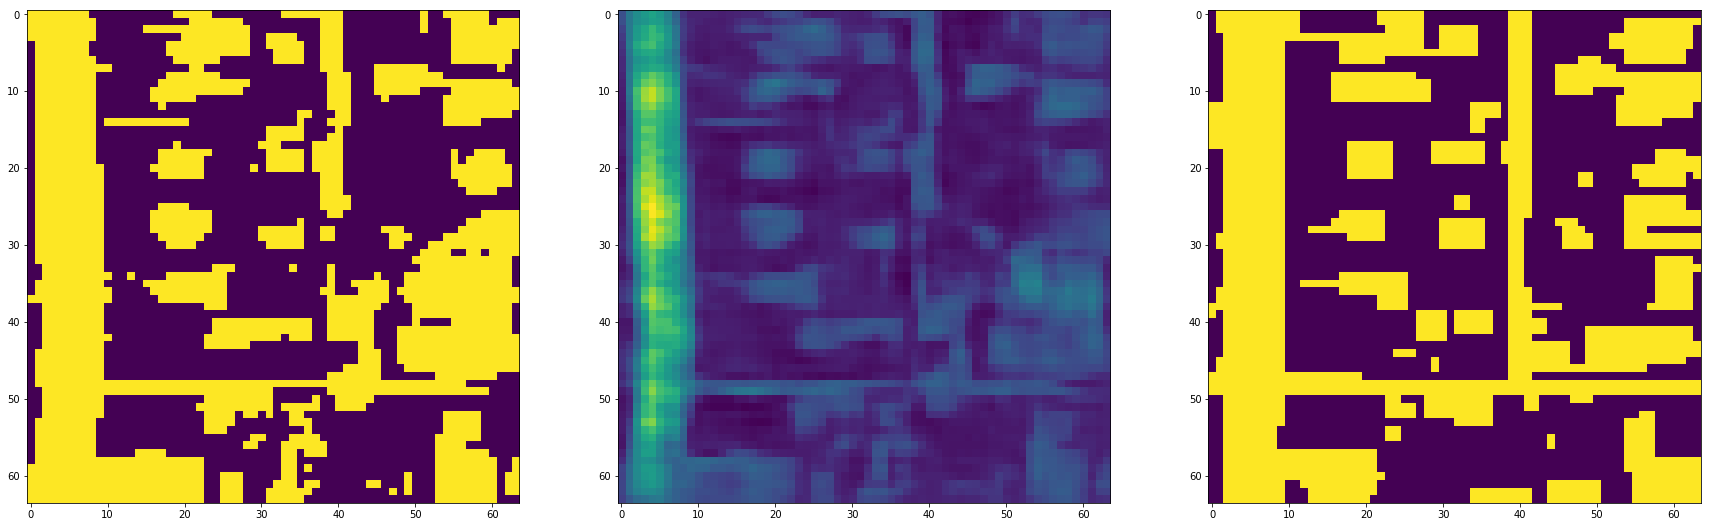

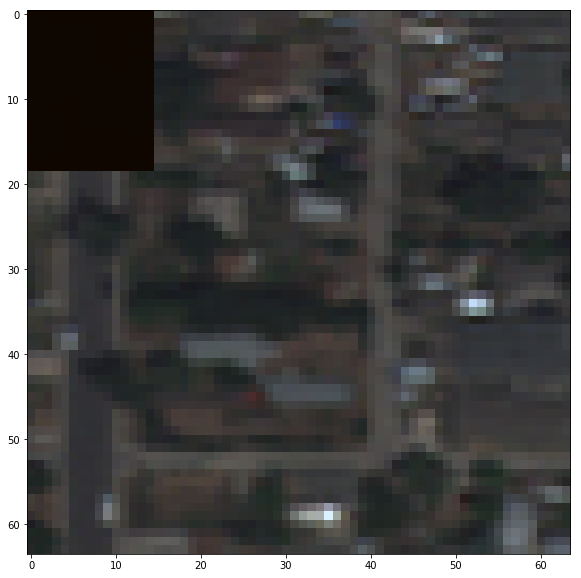

In [27]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    
    try:
        input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
        mask = model(input_img)


        mask_im = mask.squeeze().data.cpu().numpy()
        mask_binary = mask_im.copy()

        fig, ax = plt.subplots(1,3, figsize=(30,10))
        thresh = 0
        mask_binary[mask_im<=thresh] = 0
        mask_binary[mask_im>thresh] = 1
        ax[0].imshow(mask_binary)
        # ax[0].colorbar()
        ax[1].imshow(mask_im)
        gt_im = gt_dataset_test[test_ind].numpy().squeeze()
        ax[2].imshow(gt_im)
        # ax[1].colorbar()
        plt.show()

        fig = plt.figure(figsize=(10,10))
        source_im = dg_dataset_test[test_ind].numpy()
        plt.imshow(misc.bytescale(np.rollaxis(source_im[[4,2,1],:,:], 0, 3)))
        plt.show()
    
    except Exception as e:
        print(e)
        pass


In [28]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [29]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [30]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))